In [ ]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

##### A

In [116]:
# years crosswalk
years = {
    '1011': 2010, '1112': 2011, '1213': 2012,
    '1314': 2013, '1415': 2014, '1516': 2015
}

# exclued state
excluded_states = {'DC', 'FM', 'MH', 'MP', 'PR', 'PW', 'VI', 'GU', 'AS'}

# raw data path
data_dir = "/Users/songyining/Documents/MACSS/general/Li/raw_data"

# yearly data holder
yearly_data = []

for code, year in years.items():
    sfa_path = os.path.join(data_dir, f"sfa{code}.csv")
    hd_path = os.path.join(data_dir, f"hd{year}.csv")
    
    # read sfa data
    sfa = pd.read_csv(sfa_path, low_memory=False)
    sfa_clean = sfa[['UNITID', 'SCUGFFN', 'FGRNT_T']].copy()
    sfa_clean.columns = ['UNITID', 'enroll_ftug', 'grant_federal_t']
    sfa_clean['year'] = year

    # read hd data
    try:
        hd = pd.read_csv(hd_path, low_memory=False)
    except UnicodeDecodeError:
        hd = pd.read_csv(hd_path, encoding='latin1', low_memory=False)

    # clean hd
    hd_clean = hd[['UNITID', 'STABBR', 'CONTROL', 'ICLEVEL', 'UGOFFER']].copy()
    hd_clean = hd_clean[hd_clean['UGOFFER'] == 1]
    hd_clean = hd_clean[~hd_clean['STABBR'].isin(excluded_states)]
    hd_clean['degree_bach'] = (hd_clean['ICLEVEL'] == 1).astype(int)
    hd_clean['public'] = (hd_clean['CONTROL'] == 1).astype(int)

    # merge sfa and hd
    merged = pd.merge(sfa_clean, hd_clean, on='UNITID', how='inner')
    merged = merged[['UNITID', 'STABBR', 'year', 'degree_bach', 'public', 'enroll_ftug', 'grant_federal_t']]
    yearly_data.append(merged)

# merge all years
panel_df = pd.concat(yearly_data, ignore_index=True)

# balanced panel modify
school_counts = panel_df['UNITID'].value_counts()
valid_ids = school_counts[school_counts == len(years)].index
balanced_panel = panel_df[panel_df['UNITID'].isin(valid_ids)].copy()
balanced_panel = balanced_panel.rename(columns={'UNITID': 'ID_IPEDS'})
balanced_panel.reset_index(drop=True, inplace=True)

# save to CSV
output_path = "/Users/songyining/Documents/MACSS/general/Li/clean_data/clean_balanced_panel.csv"
balanced_panel.to_csv(output_path, index=False)
balanced_panel.head(5)

,ID_IPEDS,STABBR,year,degree_bach,public,enroll_ftug,grant_federal_t
0,100654,AL,2010,1,1,1110,4005894.0
1,100663,AL,2010,1,1,1542,3176808.0
2,100690,AL,2010,1,0,4,5475.0
3,100706,AL,2010,1,1,600,1239983.0
4,100724,AL,2010,1,1,1090,4558623.0


#### B

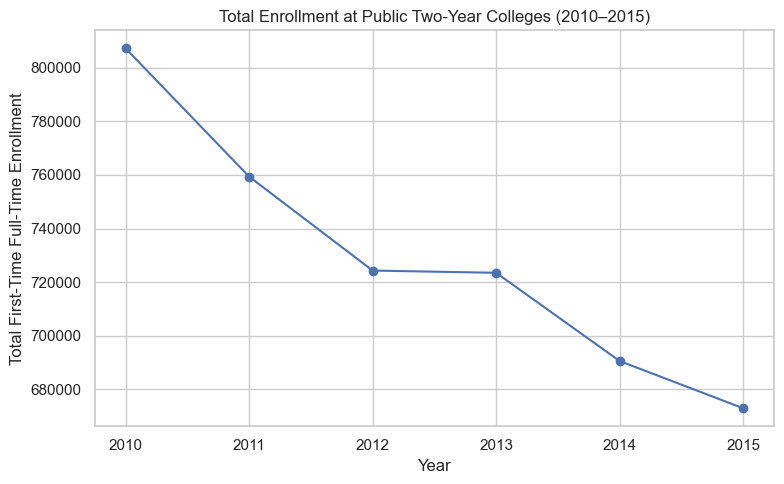

In [117]:
# Load final clean panel if not already loaded
df = pd.read_csv("/Users/songyining/Documents/MACSS/general/Li/clean_data/clean_balanced_panel.csv")

# Filter for public two-year colleges (no bachelor’s degrees)
two_year_public = df[(df['public'] == 1) & (df['degree_bach'] == 0)]

# Aggregate total enrollment by year
enrollment_trend = two_year_public.groupby('year')['enroll_ftug'].sum().reset_index()

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(enrollment_trend['year'], enrollment_trend['enroll_ftug'], marker='o', linestyle='-')
plt.title('Total Enrollment at Public Two-Year Colleges (2010–2015)')
plt.xlabel('Year')
plt.ylabel('Total First-Time Full-Time Enrollment')
plt.grid(True)
plt.tight_layout()
plt.show()


#### C

In [139]:
df_2015 = balanced_panel[balanced_panel['year'] == 2015].copy()
df_2015['per_student_grant'] = df_2015['grant_federal_t'] / df_2015['enroll_ftug']
df_2015.head()

,ID_IPEDS,STABBR,year,degree_bach,public,enroll_ftug,grant_federal_t,per_student_grant
27380,100654,AL,2015,1,1,1473,5222518.0,3545.497624
27381,100663,AL,2015,1,1,1593,2903551.0,1822.693660
27382,100690,AL,2015,1,0,6,19350.0,3225.000000
27383,100706,AL,2015,1,1,1027,1217617.0,1185.605648
27384,100724,AL,2015,1,1,1008,3959898.0,3928.470238


##### (1)

In [140]:
vt_ny = df_2015[df_2015['STABBR'].isin(['VT', 'NY'])]

# Calculate average per-student grant by state
state_avg = vt_ny.groupby('STABBR').apply(
    lambda x: (x['grant_federal_t'].sum() / x['enroll_ftug'].sum())
).reset_index(name='avg_grant_per_student')

print(state_avg)


  STABBR  avg_grant_per_student
0     NY            2317.250356
1     VT            1364.217527


/var/folders/9q/g2f90vbs3md2cg1d_26zy4xh0000gn/T/ipykernel_65822/3106211650.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  state_avg = vt_ny.groupby('STABBR').apply(


##### (2)

count      50.000000
mean     1880.764356
std       373.913539
min      1145.047463
25%      1573.689418
50%      1823.571459
75%      2158.706828
max      2773.821559
Name: avg_grant_per_student, dtype: float64


/var/folders/9q/g2f90vbs3md2cg1d_26zy4xh0000gn/T/ipykernel_65822/2834710850.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  state_stats = df_2015.groupby('STABBR').apply(


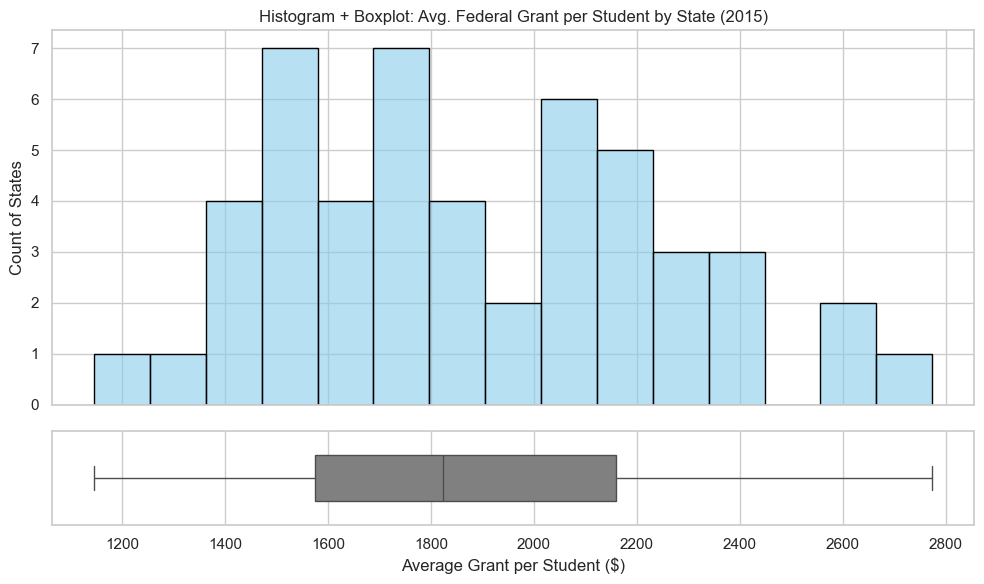

,STABBR,avg_grant_per_student
24,MS,2773.821559
8,FL,2629.666765
31,NM,2596.415977
17,LA,2369.949560
2,AR,2352.236341
9,GA,2342.254923
41,TN,2326.043157
33,NY,2317.250356
42,TX,2280.840806
4,CA,2220.122030


In [155]:
# Compute state-level average per-student grant
state_stats = df_2015.groupby('STABBR').apply(
    lambda x: (x['grant_federal_t'].sum() / x['enroll_ftug'].sum())
).reset_index(name='avg_grant_per_student')

# Summary stats
summary = state_stats['avg_grant_per_student'].describe()
print(summary)

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 6), gridspec_kw={'height_ratios': [4, 1]})
# Histogram
sns.histplot(x=state_stats['avg_grant_per_student'], bins=15, color='skyblue', edgecolor='black', alpha=0.6, ax=ax1)
ax1.set_ylabel("Count of States")
ax1.set_title("Histogram + Boxplot: Avg. Federal Grant per Student by State (2015)")
# Boxplot below
sns.boxplot(x=state_stats['avg_grant_per_student'], ax=ax2, color='gray', width=0.5)
ax2.set_yticks([])  # hide y-axis on boxplot
ax2.set_xlabel("Average Grant per Student ($)")
plt.tight_layout()
plt.show()

state_stats.sort_values(by='avg_grant_per_student',ascending=False)

##### (3)

In [ ]:
# Apply new formula
df_2015['simulated_grant'] = (
    1750 * df_2015['enroll_ftug'] + 0.15 * df_2015['enroll_ftug']**2
)
df_2015['simulated_per_student_grant'] = df_2015['simulated_grant'] / df_2015['enroll_ftug']

# # Compute spread across states under new system
sim_state = df_2015.groupby('STABBR').apply(
    lambda x: (x['simulated_grant'].sum() / x['enroll_ftug'].sum())
).reset_index(name='simulated_per_student_grant')
sim_state.columns

# Compare spread with original
comparison = pd.merge(state_stats, sim_state, on='STABBR')
comparison['diff'] = comparison['simulated_per_student_grant'] - comparison['avg_grant_per_student']
comparison.head()

/var/folders/9q/g2f90vbs3md2cg1d_26zy4xh0000gn/T/ipykernel_65822/135593247.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sim_state = df_2015.groupby('STABBR').apply(


,STABBR,avg_grant_per_student,simulated_per_student_grant,diff
0,AK,1939.860645,1881.649097,-58.211548
1,AL,2169.613381,2097.867144,-71.746236
2,AR,2352.236341,1988.094664,-364.141677
3,AZ,2052.244781,2258.364796,206.120014
4,CA,2220.122030,2083.279002,-136.843029


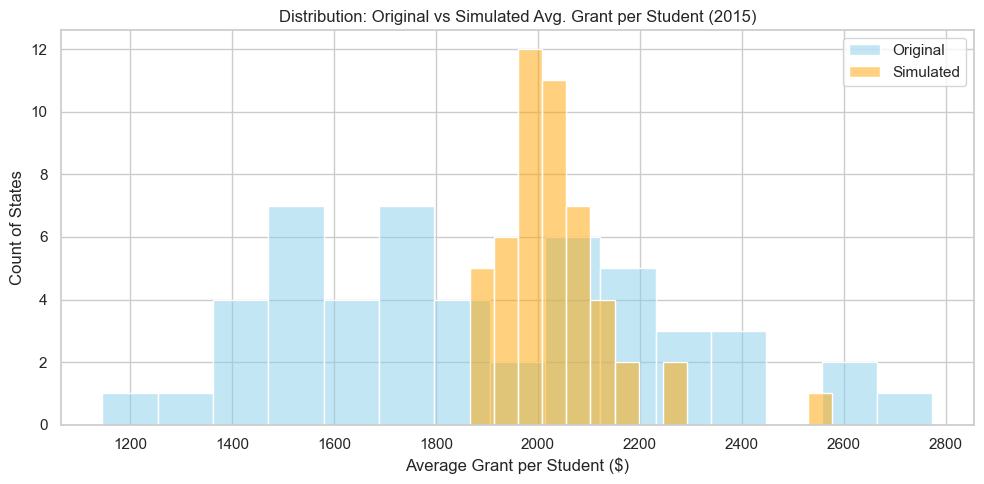

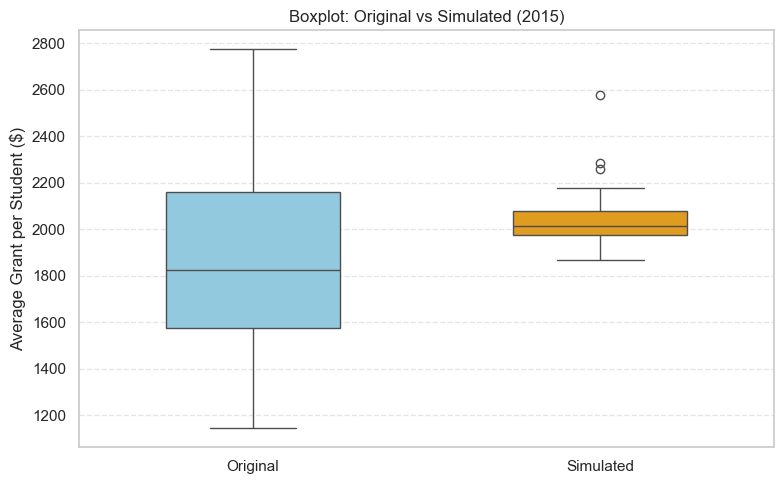

In [157]:
# Plot distribution comparison
plt.figure(figsize=(10, 5))
sns.histplot(comparison['avg_grant_per_student'], bins=15, color='skyblue', label='Original', alpha=0.5)
sns.histplot(comparison['simulated_per_student_grant'], bins=15, color='orange', label='Simulated', alpha=0.5)
plt.xlabel('Average Grant per Student ($)')
plt.ylabel('Count of States')
plt.title('Distribution: Original vs Simulated Avg. Grant per Student (2015)')
plt.legend()
plt.tight_layout()
plt.show()

# Plot boxplot comparison separately
plt.figure(figsize=(8, 5))
sns.boxplot(data=comparison[['avg_grant_per_student', 'simulated_per_student_grant']],
            palette=['skyblue', 'orange'], width=0.5)
plt.xticks([0, 1], ['Original', 'Simulated'])
plt.ylabel('Average Grant per Student ($)')
plt.title('Boxplot: Original vs Simulated (2015)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()